In [1]:
!pip install catboost -q

     |████████████████████████████████| 76.6 MB 108 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import gc
import os
from numpy import mean
from numpy import std


In [4]:
meta_tree_train = pd.read_pickle('./drive/MyDrive/save/taiwan/meta_tree_train.pkl')
meta_tree_test = pd.read_pickle('./drive/MyDrive/save/taiwan/meta_tree_test.pkl')
meta_dnn_train = pd.read_pickle('./drive/MyDrive/save/taiwan/meta_dnn_train.pkl')
meta_dnn_test = pd.read_pickle('./drive/MyDrive/save/taiwan/meta_dnn_test.pkl')
meta_lstm_train = pd.read_pickle('./drive/MyDrive/save/taiwan/meta_lstm_train.pkl')
meta_lstm_test = pd.read_pickle('./drive/MyDrive/save/taiwan/meta_lstm_test.pkl')

In [5]:
X_train = pd.read_pickle('./drive/MyDrive/save/taiwan/X_train.pkl')
X_test = pd.read_pickle('./drive/MyDrive/save/taiwan/X_test.pkl')
y_train  = pd.read_pickle('./drive/MyDrive/save/taiwan/y_train.pkl')
y_test  = pd.read_pickle('./drive/MyDrive/save/taiwan/y_test.pkl')

In [6]:
#meta classifier 8 models
meta_train = pd.concat([meta_tree_train,  meta_dnn_train, meta_lstm_train], axis = 1)
meta_test = pd.concat([meta_tree_test,  meta_dnn_test, meta_lstm_test], axis = 1)

In [7]:
n_fold = 5

In [8]:
########## Stacking only meta classifier #################

In [9]:
## LogisticRegression ##

In [10]:
stacking_only_meta = LogisticRegression(random_state=0)

In [11]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_stacking_only_meta = []
auc_score_stacking_only_meta = []
f1_stacking_only_meta = []
meta_train_stacking_only_meta = []
meta_test_stacking_only_meta = []
i = 1
for train_index, valid_index in kf.split(meta_train, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train.iloc[train_index], meta_train.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    stacking_only_meta.fit(train_X, train_y)
    ####meta
    meta_train_stacking_only_meta = np.append(meta_train_stacking_only_meta, stacking_only_meta.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_stacking_only_meta) == 0:
        meta_test_stacking_only_meta = stacking_only_meta.predict_proba(meta_test)[:,1].reshape(-1,1)
    else:
        meta_test_stacking_only_meta = np.add(meta_test_stacking_only_meta, stacking_only_meta.predict_proba(meta_test)[:,1].reshape(-1,1))
    #####
    yhat = stacking_only_meta.predict(meta_test)
    acc_score_stacking_only_meta.append(accuracy_score(yhat,y_test))
    auc_score_stacking_only_meta.append(roc_auc_score(yhat,y_test))
    f1_stacking_only_meta.append(f1_score(yhat,y_test))
    i += 1
meta_test_stacking_only_meta = np.divide(meta_test_stacking_only_meta, n_fold)

KFold 1 of 5
KFold 2 of 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9681 +- 0.001
ROC-AUC: 0.9667 +- 0.0009
F1-Score: 0.9734 +- 0.0008
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2024
           1       0.97      0.97      0.97      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



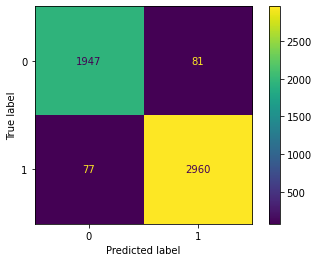

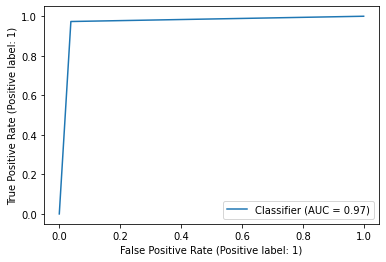

In [12]:
yhat = stacking_only_meta.predict(meta_test)
print("Accuracy: " + str(round(mean(acc_score_stacking_only_meta),4)) + " +- "+ str(round(std(acc_score_stacking_only_meta),4)))
print("ROC-AUC: " + str(round(mean(auc_score_stacking_only_meta),4)) + " +- " + str(round(std(auc_score_stacking_only_meta),4)))
print("F1-Score: " + str(round(mean(f1_stacking_only_meta),4)) +" +- "+ str(round(std(f1_stacking_only_meta),4)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [13]:
############# Stacking combine meta and raw features ##################

In [14]:
meta_train_lv0 = pd.concat([ pd.DataFrame(X_train, columns=X_train.columns).reset_index(drop=True),
                          meta_train
                       ], axis = 1)

In [15]:
meta_test_lv0 = pd.concat([ pd.DataFrame(X_test, columns=X_train.columns).reset_index(drop=True),
                          meta_test
                       ], axis = 1)

In [16]:
###### GBDT ########

In [17]:
gbdt_lv1  = GradientBoostingClassifier(n_estimators=438,
                                  learning_rate=0.06,
                                  max_depth=10,
                                  subsample = 0.55,
                                  verbose = 1,
                                  random_state=0)

In [18]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_gbdt_lv1 = []
auc_score_gbdt_lv1 = []
f1_gbdt_lv1 = []
meta_train_gbdt_lv1 = []
meta_test_gbdt_lv1 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv0, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv0.iloc[train_index], meta_train_lv0.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    gbdt_lv1.fit(train_X, train_y)
    ####meta
    meta_train_gbdt_lv1 = np.append(meta_train_gbdt_lv1, gbdt_lv1.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_gbdt_lv1) == 0:
        meta_test_gbdt_lv1 = gbdt_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1)
    else:
        meta_test_gbdt_lv1 = np.add(meta_test_gbdt_lv1, gbdt_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1))
    #####
    yhat = gbdt_lv1.predict(meta_test_lv0)
    acc_score_gbdt_lv1.append(accuracy_score(yhat,y_test))
    auc_score_gbdt_lv1.append(roc_auc_score(yhat,y_test))
    f1_gbdt_lv1.append(f1_score(yhat,y_test))
    i += 1
meta_test_gbdt_lv1 = np.divide(meta_test_gbdt_lv1, n_fold)

KFold 1 of 5
      Iter       Train Loss      OOB Improve   Remaining Time 


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         1           1.2313           0.1129            1.39m
         2           1.1323           0.0988            1.39m
         3           1.0425           0.0867            1.60m
         4           0.9593           0.0784            1.56m
         5           0.8891           0.0708            1.52m
         6           0.8219           0.0635            1.52m
         7           0.7629           0.0574            1.50m
         8           0.7101           0.0528            1.49m
         9           0.6623           0.0480            1.48m
        10           0.6166           0.0439            1.47m
        20           0.3189           0.0200            1.42m
        30           0.1719           0.0101            1.37m
        40           0.0971           0.0053            1.44m
        50           0.0557           0.0027            1.57m
        60           0.0330           0.0014            1.60m
        70           0.0210           0.0007            1.66m
        

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         2           1.1327           0.0955            1.32m
         3           1.0440           0.0853            1.35m
         4           0.9638           0.0764            1.36m
         5           0.8926           0.0684            1.37m
         6           0.8265           0.0623            1.37m
         7           0.7691           0.0565            1.36m
         8           0.7174           0.0513            1.37m
         9           0.6690           0.0467            1.37m
        10           0.6239           0.0428            1.37m
        20           0.3287           0.0194            1.35m
        30           0.1845           0.0097            1.31m
        40           0.1101           0.0049            1.28m
        50           0.0670           0.0025            1.24m
        60           0.0431           0.0012            1.21m
        70           0.0304           0.0006            1.17m
        80           0.0237           0.0004            1.14m
        

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         2           1.1299           0.0960            1.29m
         3           1.0418           0.0853            1.33m
         4           0.9631           0.0762            1.34m
         5           0.8917           0.0684            1.34m
         6           0.8274           0.0623            1.34m
         7           0.7694           0.0563            1.34m
         8           0.7170           0.0511            1.35m
         9           0.6693           0.0464            1.35m
        10           0.6235           0.0428            1.35m
        20           0.3281           0.0192            1.32m
        30           0.1835           0.0096            1.30m
        40           0.1085           0.0049            1.27m
        50           0.0659           0.0025            1.24m
        60           0.0422           0.0012            1.20m
        70           0.0302           0.0006            1.16m
        80           0.0237           0.0004            1.13m
        

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         2           1.1299           0.0955            1.28m
         3           1.0428           0.0845            1.31m
         4           0.9689           0.0758            1.33m
         5           0.8932           0.0683            1.34m
         6           0.8308           0.0621            1.34m
         7           0.7711           0.0562            1.35m
         8           0.7202           0.0508            1.36m
         9           0.6706           0.0465            1.35m
        10           0.6253           0.0424            1.36m
        20           0.3299           0.0192            1.33m
        30           0.1860           0.0096            1.29m
        40           0.1102           0.0049            1.26m
        50           0.0694           0.0026            1.22m
        60           0.0457           0.0012            1.19m
        70           0.0319           0.0006            1.16m
        80           0.0261           0.0003            1.12m
        

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


         2           1.1332           0.0954            1.27m
         3           1.0395           0.0858            1.29m
         4           0.9644           0.0754            1.31m
         5           0.8916           0.0682            1.32m
         6           0.8289           0.0618            1.32m
         7           0.7699           0.0558            1.32m
         8           0.7193           0.0504            1.33m
         9           0.6696           0.0469            1.33m
        10           0.6252           0.0425            1.33m
        20           0.3298           0.0191            1.30m
        30           0.1857           0.0096            1.27m
        40           0.1112           0.0049            1.24m
        50           0.0681           0.0026            1.20m
        60           0.0442           0.0013            1.17m
        70           0.0318           0.0007            1.14m
        80           0.0237           0.0003            1.10m
        

Accuracy: 0.969081934846989 +- 0.003065244413832237
ROC-AUC: 0.9683584547672771 +- 0.002916911339397799
F1-Score: 0.9743199918453882 +- 0.002510169475112858
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2024
           1       0.97      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



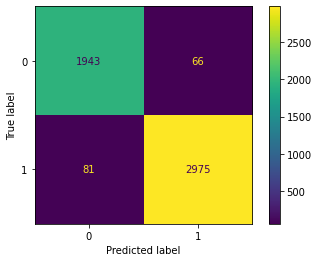

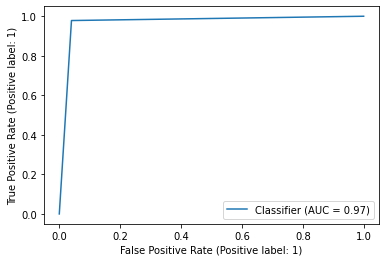

In [19]:
yhat = gbdt_lv1.predict(meta_test_lv0)
print("Accuracy: " + str(mean(acc_score_gbdt_lv1)) + " +- "+ str(std(acc_score_gbdt_lv1)))
print("ROC-AUC: " + str(mean(auc_score_gbdt_lv1)) + " +- " + str(std(auc_score_gbdt_lv1)))
print("F1-Score: " + str(mean(f1_gbdt_lv1)) +" +- "+ str(std(f1_gbdt_lv1)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [20]:
####### 1d- CNN ########

In [21]:
def EarlyStop(patience):
    return EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=patience,
    verbose=0,
    mode="auto",
)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(
                     filepath=model_name, 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 )

In [22]:
# Define 1D - CNN model
def create_model(input_shape):
    # Model Building
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(input_shape,1)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




meta_train_lv0_cnn = np.array(meta_train_lv0).reshape(-1, meta_train_lv0.shape[1], 1)
meta_test_lv0_cnn = np.array(meta_test_lv0).reshape(-1, meta_test_lv0.shape[1], 1)

# 1D-CNN model
cnn1d_lv1 = create_model(input_shape = meta_train_lv0_cnn.shape[1])

In [23]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_cnn1d_lv1 = []
auc_score_cnn1d_lv1 = []
f1_cnn1d_lv1 = []
meta_train_cnn1d_lv1 = []
meta_test_cnn1d_lv1 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv0_cnn, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv0_cnn[train_index], meta_train_lv0_cnn[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    cnn1d_lv1.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(30), ModelCheckpointFull('./cnn1d_lv1.h5')],
            verbose = 0)
    ####meta
    meta_train_cnn1d_lv1 = np.append(meta_train_cnn1d_lv1, cnn1d_lv1.predict(val_X))
    
    if len(meta_test_cnn1d_lv1) == 0:
        meta_test_cnn1d_lv1 = cnn1d_lv1.predict(meta_test_lv0_cnn)
    else:
        meta_test_cnn1d_lv1 = np.add(meta_test_cnn1d_lv1, cnn1d_lv1.predict(meta_test_lv0_cnn))
    #####
    yhat = cnn1d_lv1.predict(meta_test_lv0_cnn).round()
    acc_score_cnn1d_lv1.append(accuracy_score(yhat,y_test))
    auc_score_cnn1d_lv1.append(roc_auc_score(yhat,y_test))
    f1_cnn1d_lv1.append(f1_score(yhat,y_test))
    i += 1
meta_test_cnn1d_lv1 = np.divide(meta_test_cnn1d_lv1, n_fold)

KFold 1 of 5

Epoch 1: val_accuracy improved from -inf to 0.95262, saving model to ./cnn1d_lv1.h5

Epoch 2: val_accuracy improved from 0.95262 to 0.95607, saving model to ./cnn1d_lv1.h5

Epoch 3: val_accuracy improved from 0.95607 to 0.95706, saving model to ./cnn1d_lv1.h5

Epoch 4: val_accuracy did not improve from 0.95706

Epoch 5: val_accuracy did not improve from 0.95706

Epoch 6: val_accuracy did not improve from 0.95706

Epoch 7: val_accuracy did not improve from 0.95706

Epoch 8: val_accuracy did not improve from 0.95706

Epoch 9: val_accuracy did not improve from 0.95706

Epoch 10: val_accuracy did not improve from 0.95706

Epoch 11: val_accuracy did not improve from 0.95706

Epoch 12: val_accuracy did not improve from 0.95706

Epoch 13: val_accuracy did not improve from 0.95706

Epoch 14: val_accuracy did not improve from 0.95706

Epoch 15: val_accuracy did not improve from 0.95706

Epoch 16: val_accuracy did not improve from 0.95706

Epoch 17: val_accuracy did not improve fro

###1D-CNN Classifier###

Accuracy: 0.9716 +- 0.0014
ROC-AUC: 0.9709 +- 0.0017
F1-Score: 0.9764 +- 0.0012
159/159 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2024
           1       0.98      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



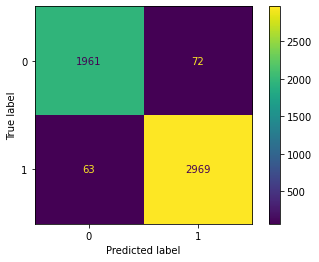

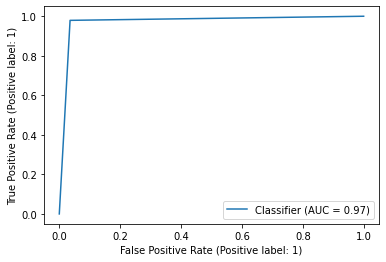

In [24]:
print("###1D-CNN Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_cnn1d_lv1),4)) + " +- "+ str(round(std(acc_score_cnn1d_lv1),4)))
print("ROC-AUC: " + str(round(mean(auc_score_cnn1d_lv1),4)) + " +- " + str(round(std(auc_score_cnn1d_lv1),4)))
print("F1-Score: " + str(round(mean(f1_cnn1d_lv1), 4)) +" +- "+ str(round(std(f1_cnn1d_lv1),4)))

yhat = cnn1d_lv1.predict(meta_test_lv0_cnn).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [25]:
## Random Forest ####

In [26]:
rf_lv1 = RandomForestClassifier(n_estimators=361,
                               random_state=42,
                           n_jobs = -1,
                           verbose = 1)

In [27]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_rf_lv1 = []
auc_score_rf_lv1 = []
f1_rf_lv1 = []
meta_train_rf_lv1 = []
meta_test_rf_lv1 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv0, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv0.iloc[train_index], meta_train_lv0.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    rf_lv1.fit(train_X, train_y)
    ####meta
    meta_train_rf_lv1 = np.append(meta_train_rf_lv1, rf_lv1.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_rf_lv1) == 0:
        meta_test_rf_lv1 = rf_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1)
    else:
        meta_test_rf_lv1 = np.add(meta_test_rf_lv1, rf_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1))
    #####
    
    yhat = rf_lv1.predict(meta_test_lv0)
    acc_score_rf_lv1.append(accuracy_score(yhat,y_test))
    auc_score_rf_lv1.append(roc_auc_score(yhat,y_test))
    f1_rf_lv1.append(f1_score(yhat,y_test))
    i += 1
meta_test_rf_lv1 = np.divide(meta_test_rf_lv1, n_fold)

KFold 1 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    6.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Paral

KFold 2 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Paral

KFold 3 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks   

KFold 4 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks   

KFold 5 of 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks   

###Random Forest Classifier###

Accuracy: 0.9709 +- 0.0014
ROC-AUC: 0.9697 +- 0.0013
F1-Score: 0.9757 +- 0.0011


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2024
           1       0.98      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



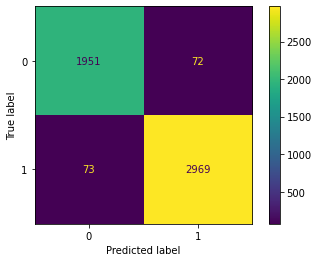

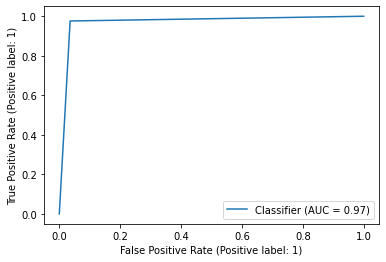

In [28]:
print("###Random Forest Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_rf_lv1), 4)) + " +- "+ str(round(std(acc_score_rf_lv1),4)))
print("ROC-AUC: " + str(round(mean(auc_score_rf_lv1),4)) + " +- " + str(round(std(auc_score_rf_lv1), 4)))
print("F1-Score: " + str(round(mean(f1_rf_lv1), 4)) +" +- "+ str(round(std(f1_rf_lv1),4)))

yhat = rf_lv1.predict(meta_test_lv0)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [29]:
### Catboost ####

In [30]:
catb_lv1 = CatBoostClassifier(iterations=450,
                           learning_rate=0.05,
                           depth=10)

In [31]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_catb_lv1 = []
auc_score_catb_lv1 = []
f1_catb_lv1 = []
meta_train_catb_lv1 = []
meta_test_catb_lv1 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv0, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv0.iloc[train_index], meta_train_lv0.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    catb_lv1.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=200, verbose = 0)
    ####meta
    meta_train_catb_lv1 = np.append(meta_train_catb_lv1, catb_lv1.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_catb_lv1) == 0:
        meta_test_catb_lv1 = catb_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1)
    else:
        meta_test_catb_lv1 = np.add(meta_test_catb_lv1, catb_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1))
    #####
    yhat = catb_lv1.predict(meta_test_lv0)
    acc_score_catb_lv1.append(accuracy_score(yhat,y_test))
    auc_score_catb_lv1.append(roc_auc_score(yhat,y_test))
    f1_catb_lv1.append(f1_score(yhat,y_test))
    i += 1
meta_test_catb_lv1 = np.divide(meta_test_catb_lv1, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5
KFold 5 of 5


###catb_lv1oost Classifier###

Accuracy: 0.9696 +- 0.0038
ROC-AUC: 0.9689 +- 0.0035
F1-Score: 0.9747 +- 0.0031
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2024
           1       0.97      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



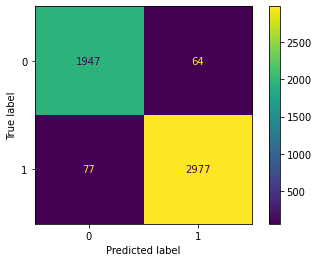

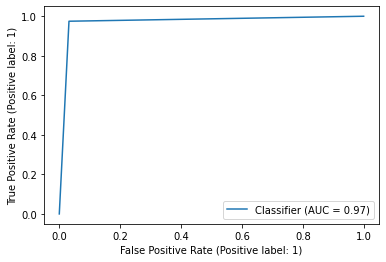

In [32]:
print("###catb_lv1oost Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_catb_lv1),4)) + " +- "+ str(round(std(acc_score_catb_lv1),4)))
print("ROC-AUC: " + str(round(mean(auc_score_catb_lv1),4)) + " +- " + str(round(std(auc_score_catb_lv1),4)))
print("F1-Score: " + str(round(mean(f1_catb_lv1),4)) +" +- "+ str(round(std(f1_catb_lv1),4)))

yhat = catb_lv1.predict(meta_test_lv0)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [33]:
######### predict level 1 meta data ##########

In [35]:
meta_train_lv1 = pd.concat([pd.DataFrame(cnn1d_lv1.predict(meta_train_lv0), columns=['cnn1d_lv1_train']),
                       pd.DataFrame(gbdt_lv1.predict_proba(meta_train_lv0)[:,1].reshape(-1,1), columns=['gbdt_lv1_train']),
                       pd.DataFrame(rf_lv1.predict_proba(meta_train_lv0)[:,1].reshape(-1,1), columns=['rf_lv1_train']),
                        pd.DataFrame(catb_lv1.predict_proba(meta_train_lv0)[:,1].reshape(-1,1), columns=['catb_lv1_train'])
                        ], axis = 1)

634/634 [==============================] - 3s 4ms/step


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.6s finished


In [36]:
meta_test_lv1 = pd.concat([pd.DataFrame(cnn1d_lv1.predict(meta_test_lv0), columns=['cnn1d_lv1_test']),
                       pd.DataFrame(gbdt_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1), columns=['gbdt_lv1_test']),
                       pd.DataFrame(rf_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1), columns=['rf_lv1_test']),
                        pd.DataFrame(catb_lv1.predict_proba(meta_test_lv0)[:,1].reshape(-1,1), columns=['catb_lv1_test'])
                        ], axis = 1)

159/159 [==============================] - 0s 3ms/step


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished


In [ ]:
###### Logistic Regression lv1 ####

In [37]:
lr_lv1 = LogisticRegression(random_state=0)

In [38]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_lr_lv1 = []
auc_score_lr_lv1 = []
f1_lr_lv1 = []
meta_train_lr_lv1 = []
meta_test_lr_lv1 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv1, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv1.iloc[train_index], meta_train_lv1.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    lr_lv1.fit(train_X, train_y)
    ####meta
    meta_train_lr_lv1 = np.append(meta_train_lr_lv1, lr_lv1.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_lr_lv1) == 0:
        meta_test_lr_lv1 = lr_lv1.predict_proba(meta_test_lv1)[:,1].reshape(-1,1)
    else:
        meta_test_lr_lv1 = np.add(meta_test_lr_lv1, lr_lv1.predict_proba(meta_test_lv1)[:,1].reshape(-1,1))
    #####
    yhat = lr_lv1.predict(meta_test_lv1)
    acc_score_lr_lv1.append(accuracy_score(yhat,y_test))
    auc_score_lr_lv1.append(roc_auc_score(yhat,y_test))
    f1_lr_lv1.append(f1_score(yhat,y_test))
    i += 1
meta_test_lr_lv1 = np.divide(meta_test_lr_lv1, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature name

KFold 5 of 5


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was

Accuracy: 0.974 +- 0.0002
ROC-AUC: 0.973 +- 0.0001
F1-Score: 0.9784 +- 0.0002
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2024
           1       0.98      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)


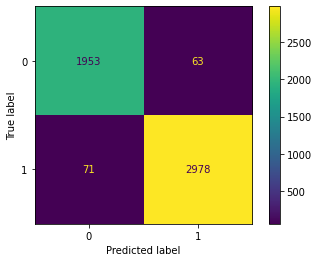

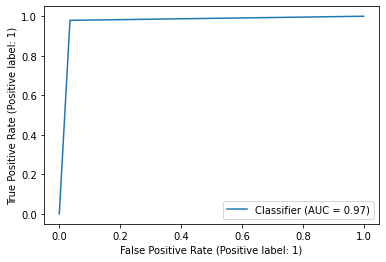

In [40]:
### Logistic regression lv1 ####
yhat = lr_lv1.predict(meta_test_lv1)
print("Accuracy: " + str(round(mean(acc_score_lr_lv1),4)) + " +- "+ str(round(std(acc_score_lr_lv1),4)))
print("ROC-AUC: " + str(round(mean(auc_score_lr_lv1),4)) + " +- " + str(round(std(auc_score_lr_lv1),4)))
print("F1-Score: " + str(round(mean(f1_lr_lv1),4)) +" +- "+ str(round(std(f1_lr_lv1),4)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()

In [43]:
##### Stacking level 2 #########

In [44]:
meta_train_lv2 = pd.concat([meta_train_lv0, meta_train_lv1], axis = 1)

In [45]:
meta_test_lv2 = pd.concat([meta_test_lv0, meta_test_lv1], axis = 1)

In [46]:
rf_lv2 = RandomForestClassifier(n_estimators=361,
                               random_state=42,
                           n_jobs = -1,
                           verbose = 1)

In [52]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_rf_lv2 = []
auc_score_rf_lv2 = []
f1_rf_lv2 = []
meta_train_rf_lv2 = []
meta_test_rf_lv2 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv2, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv2.iloc[train_index], meta_train_lv2.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    rf_lv2.fit(train_X, train_y)
    ####meta
    meta_train_rf_lv2 = np.append(meta_train_rf_lv2, rf_lv2.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_rf_lv2) == 0:
        meta_test_rf_lv2 = rf_lv2.predict_proba(meta_test_lv2)[:,1].reshape(-1,1)
    else:
        meta_test_rf_lv2 = np.add(meta_test_rf_lv2, rf_lv2.predict_proba(meta_test_lv2)[:,1].reshape(-1,1))
    #####
    
    yhat = rf_lv2.predict(meta_test_lv2)
    acc_score_rf_lv2.append(accuracy_score(yhat,y_test))
    auc_score_rf_lv2.append(roc_auc_score(yhat,y_test))
    f1_rf_lv2.append(f1_score(yhat,y_test))
    i += 1
meta_test_rf_lv2 = np.divide(meta_test_rf_lv2, n_fold)

KFold 1 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen

KFold 2 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    4.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen

KFold 3 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen

KFold 4 of 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen

KFold 5 of 5


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 361 out of 361 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n

###Random Forest Classifier###

Accuracy: 0.9736 +- 0.0003
ROC-AUC: 0.973 +- 0.0004
F1-Score: 0.978 +- 0.0003


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.4s finished


              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2024
           1       0.98      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



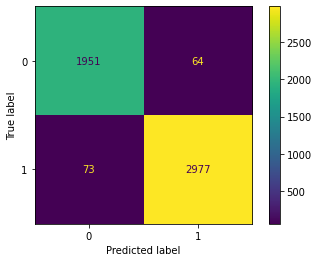

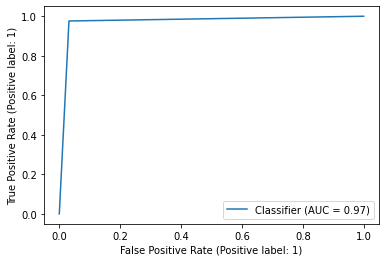

In [53]:
print("###Random Forest Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_rf_lv2), 4)) + " +- "+ str(round(std(acc_score_rf_lv2),4)))
print("ROC-AUC: " + str(round(mean(auc_score_rf_lv2),4)) + " +- " + str(round(std(auc_score_rf_lv2), 4)))
print("F1-Score: " + str(round(mean(f1_rf_lv2), 4)) +" +- "+ str(round(std(f1_rf_lv2),4)))

yhat = rf_lv2.predict(meta_test_lv2)
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [49]:
#### 1D-CNN #####

In [54]:
meta_train_lv2_cnn = np.array(meta_train_lv2).reshape(-1, meta_train_lv2.shape[1], 1)
meta_test_lv2_cnn = np.array(meta_test_lv2).reshape(-1, meta_test_lv2.shape[1], 1)

# 1D-CNN model
cnn1d_lv2 = create_model(input_shape = meta_train_lv2_cnn.shape[1])

In [56]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_cnn1d_lv2 = []
auc_score_cnn1d_lv2 = []
f1_cnn1d_lv2 = []
meta_train_cnn1d_lv2 = []
meta_test_cnn1d_lv2 = []
i = 1
for train_index, valid_index in kf.split(meta_train_lv2_cnn, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_lv2_cnn[train_index], meta_train_lv2_cnn[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    cnn1d_lv2.fit(train_X, train_y, validation_data=(val_X, val_y), epochs = 500, 
            batch_size = 256, 
            callbacks = [EarlyStop(20), ModelCheckpointFull('./cnn1d_lv2.h5')],
            verbose = 0)
    ####meta
    meta_train_cnn1d_lv2 = np.append(meta_train_cnn1d_lv2, cnn1d_lv2.predict(val_X))
    
    if len(meta_test_cnn1d_lv2) == 0:
        meta_test_cnn1d_lv2 = cnn1d_lv2.predict(meta_test_lv2_cnn)
    else:
        meta_test_cnn1d_lv2 = np.add(meta_test_cnn1d_lv2, cnn1d_lv2.predict(meta_test_lv2_cnn))
    #####
    yhat = cnn1d_lv2.predict(meta_test_lv2_cnn).round()
    acc_score_cnn1d_lv2.append(accuracy_score(yhat,y_test))
    auc_score_cnn1d_lv2.append(roc_auc_score(yhat,y_test))
    f1_cnn1d_lv2.append(f1_score(yhat,y_test))
    i += 1
meta_test_cnn1d_lv2 = np.divide(meta_test_cnn1d_lv2, n_fold)

KFold 1 of 5

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to ./cnn1d_lv2.h5

Epoch 2: val_accuracy did not improve from 1.00000

Epoch 3: val_accuracy did not improve from 1.00000

Epoch 4: val_accuracy did not improve from 1.00000

Epoch 5: val_accuracy did not improve from 1.00000

Epoch 6: val_accuracy did not improve from 1.00000

Epoch 7: val_accuracy did not improve from 1.00000

Epoch 8: val_accuracy did not improve from 1.00000

Epoch 9: val_accuracy did not improve from 1.00000

Epoch 10: val_accuracy did not improve from 1.00000

Epoch 11: val_accuracy did not improve from 1.00000

Epoch 12: val_accuracy did not improve from 1.00000

Epoch 13: val_accuracy did not improve from 1.00000

Epoch 14: val_accuracy did not improve from 1.00000

Epoch 15: val_accuracy did not improve from 1.00000

Epoch 16: val_accuracy did not improve from 1.00000

Epoch 17: val_accuracy did not improve from 1.00000

Epoch 18: val_accuracy did not improve from 1.00000

Epoch 19

###1D-CNN Classifier###

Accuracy: 0.9724 +- 0.0002
ROC-AUC: 0.9719 +- 0.0004
F1-Score: 0.9771 +- 0.0002
159/159 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2024
           1       0.97      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



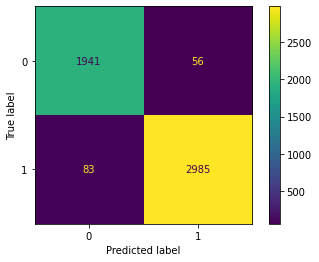

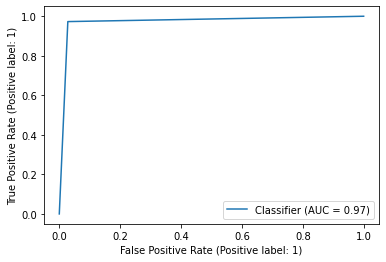

In [57]:
print("###1D-CNN Classifier###\n")
print("Accuracy: " + str(round(mean(acc_score_cnn1d_lv2),4)) + " +- "+ str(round(std(acc_score_cnn1d_lv2),4)))
print("ROC-AUC: " + str(round(mean(auc_score_cnn1d_lv2),4)) + " +- " + str(round(std(auc_score_cnn1d_lv2),4)))
print("F1-Score: " + str(round(mean(f1_cnn1d_lv2), 4)) +" +- "+ str(round(std(f1_cnn1d_lv2),4)))

yhat = cnn1d_lv2.predict(meta_test_lv2_cnn).round()
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(yhat, y_test)
plt.show()

In [58]:
######### predict level 2 meta data ##########

In [62]:
meta_train_final = pd.concat([pd.DataFrame(cnn1d_lv2.predict(meta_train_lv2), columns=['cnn1d_final_train']),
                       pd.DataFrame(rf_lv2.predict_proba(meta_train_lv2)[:,1].reshape(-1,1), columns=['rf_final_train'])
                        ], axis = 1)

634/634 [==============================] - 1s 2ms/step


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.3s finished


In [63]:
meta_test_final = pd.concat([pd.DataFrame(cnn1d_lv2.predict(meta_test_lv2), columns=['cnn1d_final_test']),
                       pd.DataFrame(rf_lv2.predict_proba(meta_test_lv2)[:,1].reshape(-1,1), columns=['rf_final_test'])
                        ], axis = 1)

159/159 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- catb_lv1_test
- cnn1d_lv1_test
- gbdt_lv1_test
- rf_lv1_test
Feature names seen at fit time, yet now missing:
- catb_lv1_train
- cnn1d_lv1_train
- gbdt_lv1_train
- rf_lv1_train

  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 361 out of 361 | elapsed:    0.2s finished


In [64]:
###### Logistic Regression lv2 ####

In [65]:
lr_lv2 = LogisticRegression(random_state=0)

In [66]:
kf = KFold(n_splits=n_fold, shuffle = False)
acc_score_lr_lv2 = []
auc_score_lr_lv2 = []
f1_lr_lv2 = []
meta_train_lr_lv2 = []
meta_test_lr_lv2 = []
i = 1
for train_index, valid_index in kf.split(meta_train_final, y_train):
    print('KFold {} of {}'.format(i,kf.n_splits))
    train_X, val_X = meta_train_final.iloc[train_index], meta_train_final.iloc[valid_index]
    train_y, val_y = y_train.iloc[train_index], y_train.iloc[valid_index]
    lr_lv2.fit(train_X, train_y)
    ####meta
    meta_train_lr_lv2 = np.append(meta_train_lr_lv2, lr_lv2.predict_proba(val_X)[:,1]).reshape(-1,1)
    
    if len(meta_test_lr_lv2) == 0:
        meta_test_lr_lv2 = lr_lv2.predict_proba(meta_test_final)[:,1].reshape(-1,1)
    else:
        meta_test_lr_lv2 = np.add(meta_test_lr_lv2, lr_lv2.predict_proba(meta_test_final)[:,1].reshape(-1,1))
    #####
    yhat = lr_lv2.predict(meta_test_final)
    acc_score_lr_lv2.append(accuracy_score(yhat,y_test))
    auc_score_lr_lv2.append(roc_auc_score(yhat,y_test))
    f1_lr_lv2.append(f1_score(yhat,y_test))
    i += 1
meta_test_lr_lv2 = np.divide(meta_test_lr_lv2, n_fold)

KFold 1 of 5
KFold 2 of 5
KFold 3 of 5
KFold 4 of 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cnn1d_final_test
- rf_final_test
Feature names seen at fit time, yet now missing:
- cnn1d_final_train
- rf_final_train

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cnn1d_final_test
- rf_final_test
Feature names seen at fit time, yet now missing:
- cnn1d_final_train
- rf_final_train

  warnings.

KFold 5 of 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cnn1d_final_test
- rf_final_test
Feature names seen at fit time, yet now missing:
- cnn1d_final_train
- rf_final_train

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cnn1d_final_test
- rf_final_test
Feature names seen at fit time, yet now missing:
- cnn1d_final_train
- rf_final_train

  warnings.

Accuracy: 0.9726 +- 0.0001
ROC-AUC: 0.9724 +- 0.0001
F1-Score: 0.9773 +- 0.0001
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2024
           1       0.97      0.98      0.98      3041

    accuracy                           0.97      5065
   macro avg       0.97      0.97      0.97      5065
weighted avg       0.97      0.97      0.97      5065



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- cnn1d_final_test
- rf_final_test
Feature names seen at fit time, yet now missing:
- cnn1d_final_train
- rf_final_train

  warnings.warn(message, FutureWarning)


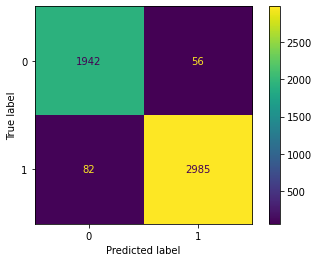

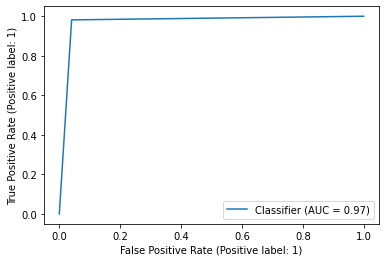

In [67]:
### Logistic regression lv2 ####
yhat = lr_lv2.predict(meta_test_final)
print("Accuracy: " + str(round(mean(acc_score_lr_lv2),4)) + " +- "+ str(round(std(acc_score_lr_lv2),4)))
print("ROC-AUC: " + str(round(mean(auc_score_lr_lv2),4)) + " +- " + str(round(std(auc_score_lr_lv2),4)))
print("F1-Score: " + str(round(mean(f1_lr_lv2),4)) +" +- "+ str(round(std(f1_lr_lv2),4)))
print(classification_report(y_test, yhat))
cm = confusion_matrix(yhat, y_test,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
RocCurveDisplay.from_predictions(y_test, yhat)
plt.show()